In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [3]:
import os

os.chdir('/content/drive/MyDrive/srikaran')
os.getcwd()

'/content/drive/MyDrive/srikaran'

In [4]:
os.makedirs('/content/datasets')

In [5]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [6]:
zip_path = '/content/drive/My Drive/srikaran/coco.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [7]:
!ls /content/datasets/train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [9]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')
os.getcwd()

'/content/drive/My Drive/srikaran/gi-tract-image-segmentation'

In [10]:
from src.data import SegmentationDataset
from src.data import DataGenerator
from src.model import SimpleUNet
from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks, display_comparison

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [12]:
train_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


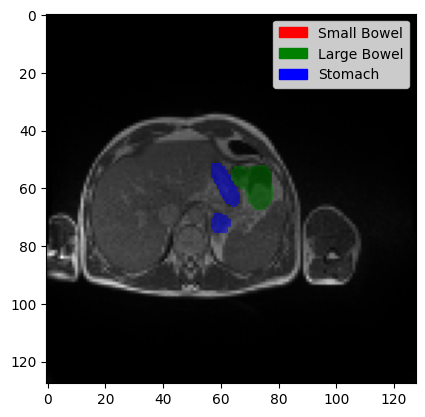

In [13]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(0)

plot_masks(X, y)

In [14]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [15]:
print("Batch size:", train_loader.batch_size)
print("Num workers:", train_loader.num_workers)
print("Dataset size:", len(train_loader.dataset))
print("Number of batches:", len(train_loader))

Batch size: 32
Num workers: 0
Dataset size: 14269
Number of batches: 446


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [67]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)  # Example input
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


In [70]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

229981

In [71]:
model = SimpleUNet().to(device)  # Ensure your model is defined or loaded

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Criterion
criterion = DiceLoss().to(device)
iou_criterion = IoU().to(device)

In [72]:
# Training and validation loops
train_losses = []
train_iou_0 = [] # small bowel
train_iou_1 = [] # large bowel
train_iou_2 = [] # stomach

val_losses = []
val_iou_0 = []
val_iou_1 = []
val_iou_2 = []

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    iou_meter_0 = AverageMeter()
    iou_meter_1 = AverageMeter()
    iou_meter_2 = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        iou_0, iou_1, iou_2 = iou_criterion(output, target)
        iou_meter_0.update(iou_0.item(), data.size(0))
        iou_meter_1.update(iou_1.item(), data.size(0))
        iou_meter_2.update(iou_2.item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_iou_0.append(iou_meter_0.avg)
    train_iou_1.append(iou_meter_1.avg)
    train_iou_2.append(iou_meter_2.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_iou_meter_0 = AverageMeter()
    val_iou_meter_1 = AverageMeter()
    val_iou_meter_2 = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            iou_0, iou_1, iou_2 = iou_criterion(output, target)
            val_iou_meter_0.update(iou_0.item(), data.size(0))
            val_iou_meter_1.update(iou_1.item(), data.size(0))
            val_iou_meter_2.update(iou_2.item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_iou_0.append(val_iou_meter_0.avg)
    val_iou_1.append(val_iou_meter_1.avg)
    val_iou_2.append(val_iou_meter_2.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, \n \
            Train IOU SB: {iou_meter_0.avg:.4f}, Val IOU SB: {val_iou_meter_0.avg:.4f}, \n \
            Train IOU LB: {iou_meter_1.avg:.4f}, Val IOU LB: {val_iou_meter_1.avg:.4f}, \n \
            Train IOU S: {iou_meter_2.avg:.4f}, Val IOU S: {val_iou_meter_2.avg:.4f}')
    # Save model checkpoint
    torch.save(model.state_dict(), f'small_UNET_model_epoch_{epoch}.pth')


Epoch 0 Validation: 100%|██████████| 145/145 [00:39<00:00,  3.71it/s]


Epoch 0: Train Loss: 0.4295, Val Loss: 0.4100, 
             Train IOU SB: 0.2716, Val IOU SB: 0.3728, 
             Train IOU LB: 0.4261, Val IOU LB: 0.5375, 
             Train IOU S: 0.4214, Val IOU S: 0.5288


Epoch 1 Validation: 100%|██████████| 145/145 [00:39<00:00,  3.64it/s]


Epoch 1: Train Loss: 0.1895, Val Loss: 0.3308, 
             Train IOU SB: 0.3865, Val IOU SB: 0.4350, 
             Train IOU LB: 0.6182, Val IOU LB: 0.6243, 
             Train IOU S: 0.6067, Val IOU S: 0.6392


Epoch 2 Validation: 100%|██████████| 145/145 [00:38<00:00,  3.77it/s]


Epoch 2: Train Loss: 0.1394, Val Loss: 0.3031, 
             Train IOU SB: 0.4324, Val IOU SB: 0.4411, 
             Train IOU LB: 0.6662, Val IOU LB: 0.6480, 
             Train IOU S: 0.6647, Val IOU S: 0.6769


Epoch 3 Validation: 100%|██████████| 145/145 [00:39<00:00,  3.70it/s]


Epoch 3: Train Loss: 0.1142, Val Loss: 0.2782, 
             Train IOU SB: 0.4648, Val IOU SB: 0.4889, 
             Train IOU LB: 0.6902, Val IOU LB: 0.6793, 
             Train IOU S: 0.6957, Val IOU S: 0.7098


Epoch 4 Validation: 100%|██████████| 145/145 [00:39<00:00,  3.71it/s]


Epoch 4: Train Loss: 0.0969, Val Loss: 0.2963, 
             Train IOU SB: 0.4907, Val IOU SB: 0.4792, 
             Train IOU LB: 0.7071, Val IOU LB: 0.6550, 
             Train IOU S: 0.7191, Val IOU S: 0.6748


Epoch 5 Validation: 100%|██████████| 145/145 [00:38<00:00,  3.74it/s]


Epoch 5: Train Loss: 0.0852, Val Loss: 0.2992, 
             Train IOU SB: 0.5076, Val IOU SB: 0.5139, 
             Train IOU LB: 0.7215, Val IOU LB: 0.6907, 
             Train IOU S: 0.7309, Val IOU S: 0.6213


Epoch 6 Validation: 100%|██████████| 145/145 [00:39<00:00,  3.68it/s]


Epoch 6: Train Loss: 0.0749, Val Loss: 0.2589, 
             Train IOU SB: 0.5224, Val IOU SB: 0.5220, 
             Train IOU LB: 0.7300, Val IOU LB: 0.7126, 
             Train IOU S: 0.7446, Val IOU S: 0.7237


Epoch 7 Validation: 100%|██████████| 145/145 [00:38<00:00,  3.76it/s]


Epoch 7: Train Loss: 0.0629, Val Loss: 0.2667, 
             Train IOU SB: 0.5399, Val IOU SB: 0.5495, 
             Train IOU LB: 0.7441, Val IOU LB: 0.7252, 
             Train IOU S: 0.7578, Val IOU S: 0.7091


Epoch 8 Validation: 100%|██████████| 145/145 [00:40<00:00,  3.58it/s]


Epoch 8: Train Loss: 0.0604, Val Loss: 0.2412, 
             Train IOU SB: 0.5464, Val IOU SB: 0.5508, 
             Train IOU LB: 0.7487, Val IOU LB: 0.7398, 
             Train IOU S: 0.7591, Val IOU S: 0.7507


Epoch 9 Validation: 100%|██████████| 145/145 [00:39<00:00,  3.66it/s]


Epoch 9: Train Loss: 0.0511, Val Loss: 0.2796, 
             Train IOU SB: 0.5607, Val IOU SB: 0.5462, 
             Train IOU LB: 0.7583, Val IOU LB: 0.6951, 
             Train IOU S: 0.7711, Val IOU S: 0.7060


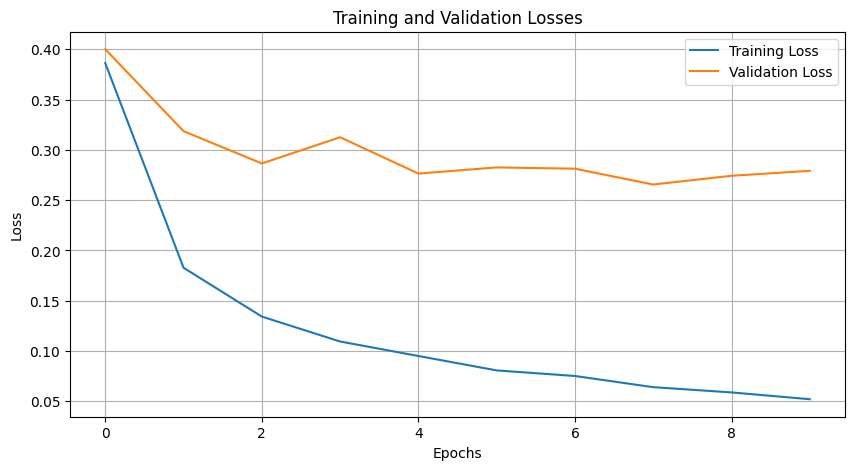

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
model = SimpleUNet().to(device)

# Load the saved model weights
model.load_state_dict(torch.load('small_UNET_model_epoch_7.pth'))

# Set the model to evaluation mode if you are making predictions
model.eval()

SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu2): LeakyReLU(negative_slope=0.1)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(128, eps=1e-05, m

In [74]:
test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/test_json.json',
                                     shuffle=False)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [76]:
images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data in test_loader:
        # Assuming your DataLoader returns a tuple of (images, labels)
        images = data[0]
        images = images.permute(0, 3, 1, 2).to(device)
        images_test.append(images)
        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)
        mask = data[1].permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)
        # print(iou_value0, iou_value1, iou_value2)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))

print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

Test Dice Loss: 0.2522, 
         IOU for SB:  0.5463, 
         IOU for LB:  0.7323, 
         IOU for S:  0.7113


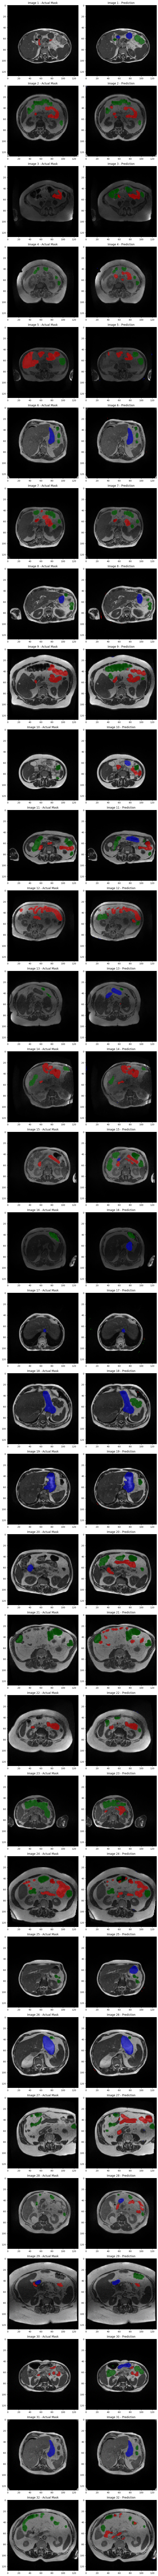

In [63]:
img_s = images_test[0]
pred_s = predictions[0]
mask_s = masks[0]

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())